# Model overview
## Agent properties
- (Competence) Grammar: ranking of constraints.
- (Performance) SA-OT mechanism: for production & optimization of forms.
- (Learning algorithm) Gradual Learning Algo (GLA): adjust constraint rankings from observed data.

## Model logic (procedure)
- Initialization: Grammar of Gen 0 agents is fixed to preverbal negation (Hierarchy 1).
- Iterated learning: Each next generation learns from the SA-OT-produced utterances of the previous gen using GLA. 
- Transition monitoring: record production sample at each generation -> to study the evolution of the distribution of grammars across generations.

## Metrics
- Distribution of grammatical forms in the recorded sample for each generation. 

# Libraries & global variables

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.datacollection import DataCollector

In [2]:
# Set random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

CONSTRAINTS = ["Faith[Neg]", "*Neg", "NegFirst", "NegLast"]

HIERARCHIES = {
    "H1": ["Faith[Neg]", "*Neg",     "NegFirst", "NegLast"],
    "H2": ["Faith[Neg]", "NegFirst", "*Neg",     "NegLast"],
    "H3": ["Faith[Neg]", "NegFirst", "NegLast",  "*Neg"],
    "H4": ["Faith[Neg]", "NegLast",  "NegFirst", "*Neg"],
    "H5": ["Faith[Neg]", "NegLast",  "*Neg",     "NegFirst"],
    "H6": ["Faith[Neg]", "*Neg",     "NegLast",  "NegFirst"]
}

K_VALUES = np.array([4, 3, 2, 1])  # NOTE: These are values associated with the ranks 
                                      # (NOT the ranks themselves), such that
                                      # the higher the rank, the higher the K-value.
                                      # The rank is given by the index of the K-value in the array
                                      # (index 0 is the highest rank, index -1 is the lowest rank).

RESTRICTED_CANDIDATE_SPACE = [
    ["V"],
    ["V","N"],
    ["N", "V"],
    [["N","V"], "N"],
    [["V","N"],"N"],
    ["N",["N","V"]],
    ["N",["V","N"]]
]

# Setting up model components

## Generating candidates

In [3]:
# Generate surface form (sf) for candidate
def generate_sf(depth):
    """Recursively generate a surface form (sf) for a candidate as a nested list."""
    if depth == 0:
        return "V"  # Base case: terminal node with the main verb

    # Randomly decide whether to prepend or append the SN marker
    structure_choice = random.choice(['pre', 'post'])

    if structure_choice == 'pre':
        # Add an N node before the verb or child structure
        left_child = generate_sf(depth - 1)
        return ["N", left_child]
    else:
        # Add an N node after the verb or child structure
        left_child = generate_sf(depth - 1)
        return [left_child, "N"]

def generate_candidate(polarity='negative', depth=2):
    """
    Generate a candidate pair of underlying (uf) and surface forms (sf).
    
    Parameters:
        depth (int): Depth parameter for `generate_sf()`.
        polarity (str): Desired polarity of the underlying form ('negative' or 'positive').
        
    Returns:
        tuple: A tuple of (uf, sf) if successful.
        
    Raises:
        ValueError: If depth is incompatible with the given polarity or the generated polarity doesn't match.
    """
    # Validate depth based on polarity
    if polarity == 'positive' and depth != 0:
        raise ValueError("For polarity='positive', depth must be 0.")
    if polarity == 'negative' and depth < 1:
        raise ValueError("For polarity='negative', depth must be greater than 0.")

    # Generate surface form (sf)
    sf = generate_sf(depth)
    
    # Convert to list if necessary
    if isinstance(sf, str):
        sf = [sf]

    # Determine polarity of the generated candidate
    uf = 'negative' if 'N' in sf else 'positive'

    # Validate polarity
    if uf != polarity:
        raise ValueError(f"Generated candidate polarity '{uf}' does not match the desired polarity '{polarity}'.")

    return uf, sf

def determine_polarity(sf):
    """Determine the polarity of a surface form (sf)."""
    return 'negative' if 'N' in sf else 'positive'

# Generate 3 random candidates (uf, sf) and print their tree and linear forms
uf, sf = generate_candidate(polarity='positive', depth=0)
print(f"uf: {uf}, sf: {sf}") 

for i in range(1,4):
    uf, sf = generate_candidate(polarity='negative', depth=i)  
    print(f"uf: {uf}, sf: {sf}") 

uf: positive, sf: ['V']
uf: negative, sf: ['N', 'V']
uf: negative, sf: ['N', ['V', 'N']]
uf: negative, sf: ['N', ['N', ['N', 'V']]]


In [4]:
# Helper functions for linearizing, serializing, and parsing trees

def linearize_tree(sf):
    """
    Flatten the nested list structure of the surface form into a linear representation.
    
    Args:
        sf (list or str): A nested list or a string representing the surface form.
        
    Returns:
        list: A non-nested list representation.
    """
    if isinstance(sf, str):  # Base case: single node
        return [sf]
    else:  # Recursive case: flatten the subtrees
        return [item for subtree in sf for item in linearize_tree(subtree)]

def serialize_tree(tree):
    """
    Serialize a nested list into a string representation.
    Input:
        ["SN", ["V", "SN"]]
    Output:
        "[SN [V SN]]"
    """
    if isinstance(tree, str):
        return tree
    return "[" + " ".join(serialize_tree(subtree) for subtree in tree) + "]"

def parse_tree(candidate_str):
    """
    Parse a string representation into a nested list.
    Input:
        "[SN [V SN]]"
    Output:
        ["SN", ["V", "SN"]]
    """
    stack = []
    current = []
    token = ""
    for char in candidate_str:
        if char == "[":
            stack.append(current)
            current = []
        elif char == "]":
            if token:
                current.append(token.strip())
                token = ""
            last = stack.pop()
            last.append(current)
            current = last
        elif char.isspace() and token:
            current.append(token.strip())
            token = ""
        else:
            token += char
    return current[0]

candidate_tree = generate_candidate(depth=2)[1]
print(candidate_tree)

serialized_tree = serialize_tree(candidate_tree)
print(serialized_tree)

parsed_tree = parse_tree(serialized_tree)
print(parsed_tree)

['N', ['N', 'V']]
[N [N V]]
['N', ['N', 'V']]


## Generating neighbors

In [5]:
# Helper function to remove brackets around 'V'
def remove_V_brackets(candidate):
    """
    Removes brackets around 'V' recursively within a tree-like structure.
    """
    if isinstance(candidate, list):
        # If candidate is a single-element list containing 'V'
        if len(candidate) == 1 and candidate[0] == 'V':  
            return 'V'  # Return the scalar value
        # Recursively process elements within the candidate
        return [remove_V_brackets(sub) for sub in candidate]
    return candidate  # Return non-list items as they are

c = [[['V'], 'N'], 'N']
print(f'Testing remove_v_brackets() function: {c} --> {remove_V_brackets(c)}\n')

# Creating neighbors
def generate_neighbors(candidate):
    """
    Generate neighbors of a given candidate.
    Input:
        candidate: List representing the binary tree, e.g., ["N", ["V", "N"]]
    Output:
        List of candidates, each represented as a nested list.
    """
    # Initialize list of neighbors
    neighbors = []
    
    # Add SN to the left
    neighbors.append(["N", candidate])
    # Add SN to the right
    neighbors.append([candidate, "N"])
    
    # Remove the uppermost layer
    if candidate[0] == "N":
        inner = candidate[1:][0]
        neighbors.append(inner)
    elif candidate[-1] == "N":
        inner = candidate[:-1][0]
        neighbors.append(inner)
    # if 
    
    # Reverse the order of nodes if the candidate has 2 elements
    if isinstance(candidate, list) and len(candidate) == 2:
        neighbors.append(candidate[::-1]) 
    
    # Recursively apply reversals to subtrees
    for i, subtree in enumerate(candidate):
        if isinstance(subtree, list):  # Apply to each subtree
            modified = candidate[:i] + [subtree[::-1]] + candidate[i + 1:]
            neighbors.append(modified)
    
    # Flatten neighbors that contain an isolated 'V'
    neighbors = [remove_V_brackets(neighbor) for neighbor in neighbors]
    neighbors = [neighbor if isinstance(neighbor, list) else [neighbor] for neighbor in neighbors] 
    
    return neighbors

# Generate neighbors for a candidate
candidate = ['N', ['V', 'N']]
neighbors = generate_neighbors(candidate)
for neighbor in neighbors:
    print(neighbor)

Testing remove_v_brackets() function: [[['V'], 'N'], 'N'] --> [['V', 'N'], 'N']

['N', ['N', ['V', 'N']]]
[['N', ['V', 'N']], 'N']
['V', 'N']
[['V', 'N'], 'N']
['N', ['N', 'V']]


## Harmony

In [6]:
# Define harmony function
def harmony(candidate):
    """Assigns a violation profile to the candidate:
    the number of violation marks assigned by each constraint."""
    
    candidate = linearize_tree(candidate)  # NOTE: Candidates with the same linear structure receive the same harmony.
                                           # Using the linear structure simplifies the computation of harmony. 
    
    violation_profile = {
        "Faith[Neg]": 0 if "N" in candidate else 1,      # polarity; fixed to always have highest rank and K-value
        "*Neg": candidate.count("N"),                    # 1 violation mark per N in the candidate surface form
        "NegFirst": 0 if candidate[0] == "N" else 1,     # 1 violation mark if no preverbal N
        "NegLast": 0 if candidate[-1] == "N" else 1,     # 1 violation mark if no postverbal N
    }
    
    return violation_profile


# Test the `harmony` function
print("Harmony of a sample of candidates:")
violations_df = pd.DataFrame([harmony(c) for c in RESTRICTED_CANDIDATE_SPACE], 
                             columns=CONSTRAINTS, 
                             index=[str(c) for c in RESTRICTED_CANDIDATE_SPACE])
display(violations_df)  

# NOTE: The results are consistent with the table in Lopopolo & Biro (2011). 
# NOTE: [['N', 'V'], 'N'] and ['N', ['V', 'N']] have the same harmony value, the same as their shared linear form ['N', 'V', 'N'].

Harmony of a sample of candidates:


,Faith[Neg],*Neg,NegFirst,NegLast
['V'],1,0,1,1
"['V', 'N']",0,1,1,0
"['N', 'V']",0,1,0,1
"[['N', 'V'], 'N']",0,2,0,0
"[['V', 'N'], 'N']",0,2,1,0
"['N', ['N', 'V']]",0,2,0,1
"['N', ['V', 'N']]",0,2,0,0


In [7]:
def is_more_harmonic(constraint_hierarchy, w1, w2):
    """
    Compare the harmony of two candidates based on a lexicographic order of violations.
    
    Args:
        constraint_hierarchy (list): A list of constraints ordered from the most important to the least important.
        w1 (list): Surface form of the first candidate to be compared.
        w2 (list): Surface form of the second candidate to be compared.
        
    Returns:
        tuple: A tuple containing a boolean and the fatal constraint. 
               The boolean indicates whether the first candidate (w1) is more harmonic (True) 
               or the second candidate (w2) is more harmonic (False).
               If both candidates are equally harmonic, the function returns None.
        
    Note:
        Candidate w1 is considered more harmonic than w2 if H(w1) < H(w2) in lexicographic order,
        where H(w) refers to the harmony of candidate w (i.e., a dictionary of constraint violations).
    """
    # Compute harmony (violation marks) for each candidate
    h1 = harmony(w1)
    h2 = harmony(w2)
    
    # Compare candidates based on the highest ranked constraint in the hierarchy where they differ
    for constraint in constraint_hierarchy:
        if h1[constraint] < h2[constraint]:
            # w1 violates fewer violations for this fatal constraint and is therefore more harmonic
            return True, constraint
        elif h1[constraint] > h2[constraint]:
            # w2 violates fewer violations for this fatal constraint and is therefore more harmonic
            return False, constraint
    
    return None, constraint  # Both candidates are equally harmonic 


# Test the `is_more_harmonic` function
print("Determining whether one candidate is more hamonic than another:\n")
w1 = ["N", "V", "N"]
w2 = ["V", "N"]
print(f'- Harmony of {w1}:\n\t{harmony(w1)}')
print(f'- Harmony of {w2}:\n\t{harmony(w2)}')

hierarchy = HIERARCHIES["H1"]
print(f'-> Is {w1} more harmonic than {w2} according to H1? {is_more_harmonic(hierarchy, w1, w2)[0]} (fatal constraint: {is_more_harmonic(hierarchy, w1, w2)[1]})')

Determining whether one candidate is more hamonic than another:

- Harmony of ['N', 'V', 'N']:
	{'Faith[Neg]': 0, '*Neg': 2, 'NegFirst': 0, 'NegLast': 0}
- Harmony of ['V', 'N']:
	{'Faith[Neg]': 0, '*Neg': 1, 'NegFirst': 1, 'NegLast': 0}
-> Is ['N', 'V', 'N'] more harmonic than ['V', 'N'] according to H1? False (fatal constraint: *Neg)


In [8]:
def find_most_harmonic_candidate(candidate_space, constraint_hierarchy):
    """
    Find the most harmonic candidate from a set of candidates based on a lexicographic comparison 
    of their harmony profiles using a given constraint hierarchy.

    Args:
        candidate_space (list): A list of candidate candidates.
        constraint_hierarchy (list): A list of constraints ordered by importance.

    Returns:
        list: The most harmonic candidate in the space.
    """
    # Initialize with the first candidate
    most_harmonic = candidate_space[0]
    
    # Compare each candidate to the current most harmonic one
    for candidate in candidate_space[1:]:
        is_more_harmonic_flag, _ = is_more_harmonic(constraint_hierarchy, candidate, most_harmonic)
        
        # If candidate is more harmonic, update the most harmonic candidate
        if is_more_harmonic_flag:
            most_harmonic = candidate
    
    return most_harmonic

# Test the `find_most_harmonic_candidate` function
global_optima = {}

for hierarchy_name, hierarchy in HIERARCHIES.items():
    global_optima[hierarchy_name] = find_most_harmonic_candidate(RESTRICTED_CANDIDATE_SPACE, hierarchy)
    print(f"Most harmonic candidate with {hierarchy_name} is: {global_optima[hierarchy_name]}")

Most harmonic candidate with H1 is: ['N', 'V']
Most harmonic candidate with H2 is: ['N', 'V']
Most harmonic candidate with H3 is: [['N', 'V'], 'N']
Most harmonic candidate with H4 is: [['N', 'V'], 'N']
Most harmonic candidate with H5 is: ['V', 'N']
Most harmonic candidate with H6 is: ['V', 'N']


## SA-OT algo

Pseudo-code by Lopopolo & Biro (2011): 

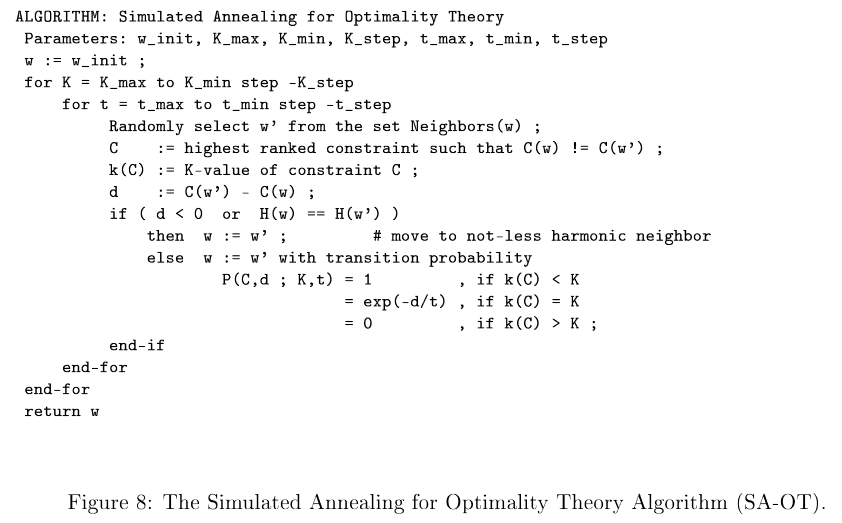

In [9]:
def sa_ot(constraint_hierarchy, Kvalues=None, w_init=["V"], K_max=5, K_min=0, K_step=1, t_max=3, t_min=0, t_step=1, max_no_move=50):
    """
    Simulated Annealing for Optimality Theory (SA-OT).
    
    Args:
        constraint_hierarchy (list): List of ranked constraints.
        Kvalues (dict, optional): Custom K-values for constraints. Default is None.
        w_init (list): Initial candidate.
        K_max (int): Maximum value of K. Default is 5.
        K_min (int): Minimum value of K. Default is 0.
        K_step (int): Step size for decreasing K. Default is 1.
                      NOTE: Not used in the current implementation; 
                      instead no_move_count is used as a stopping criterion.
        t_max (int): Maximum temperature. Default is 3.
        t_min (int): Minimum temperature. Default is 0. 
        t_step (int): Step size for decreasing temperature. Default is 1.
        max_no_move (int): Maximum iterations with no move before stopping. Default is 50.

    Returns:
        list (of lists): The local optimum found by the algorithm.
    """
    current = w_init
    iterations = 0
    no_move_count = 0  # Counter for consecutive no-move iterations

    # Outer loop over temperature K values, stops when no movement has been made for max_no_move iterations
    K = K_max
    while no_move_count < max_no_move:        
        # Inner loop over temperature values
        for t in np.arange(t_max, t_min, -t_step):
            iterations += 1

            # Generate neighbors of the current candidate
            neighbors = generate_neighbors(current)
            neighbor = random.choice(neighbors)
            
            # Find harmony values and fatal constraint
            H_current = harmony(current)
            H_neighbor = harmony(neighbor)
            _, C = is_more_harmonic(constraint_hierarchy, current, neighbor)
            
            # Get K-value for the fatal constraint
            if Kvalues is None:
                Kvalue_C = len(constraint_hierarchy) - constraint_hierarchy.index(C)
            else:
                Kvalue_C = Kvalues[C]
            
            # Calculate difference in violations for the fatal constraint
            d = H_neighbor[C] - H_current[C]
            
            
            # Decision logic for accepting the neighbor
            # Move to neighbor if it is at least as harmonic
            if d < 0 or H_neighbor == H_current:
                current = neighbor
                no_move_count = 0  
                continue
            
            # Move to neighbor if K-value of fatal constraint is less than temperature K
            elif Kvalue_C < K:
                current = neighbor
                no_move_count = 0  
                continue
            
            # Stay if K-value of fatal constraint is larger than temperature K
            elif Kvalue_C > K:
                no_move_count += 1  
                continue
            
            # Move with temperature-based, decreasing probability if K-value of fatal constraint equals temperature K
            elif random.random() < np.exp(-d / t):
                current = neighbor
                no_move_count = 0  
                continue
            
            # Don't move otherwise
            else:
                no_move_count += 1 
                continue
        
        # Decrease temperature K
        K -= K_step
    return current  # Return the candidate as the local optimum

h = HIERARCHIES['H2']
print(f"Chosen constraint hierarchy: {h}\n")
local_optimum = sa_ot(h)
print(f"Local optimum found: {local_optimum}")

Chosen constraint hierarchy: ['Faith[Neg]', 'NegFirst', '*Neg', 'NegLast']

Local optimum found: ['N', ['V', 'N']]


### Test SA-OT on all landscapes + different K-values for lowest constraint

In [12]:
### RUn SA-OT with each constraint ranking ###

total_evaluations = 100  # Number of evaluations for each K-value of the lowest-ranked constraint

results = np.zeros((6,4))  # Will store percentage of each negation type produced for each hierarchy

# Loop over each hierarchy
for idx, (hierarchy_name, hierarchy) in enumerate(HIERARCHIES.items()):
    # Initialize counts for each negation type
    count_patterns = np.zeros(4, dtype=int)

    # Perform the SA-OT algorithm total_evaluations times with the current hierarchy
    for _ in range(total_evaluations):
        local_optimum = sa_ot(hierarchy)
        # Linearize the obtained local optimum and convert it to a string to map it to a negation type
        if local_optimum == ['N', 'V']:
            count_patterns[0] += 1
        elif local_optimum == ['V', 'N']:
            count_patterns[1] += 1
        elif linearize_tree(local_optimum) == ['N', 'V', 'N']:
            count_patterns[2] += 1
        else:
            count_patterns[3] += 1
    
    count_patterns = count_patterns / total_evaluations * 100 # Convert counts to percentages
    results[idx] = count_patterns  # Store the percentage of preverbal negations for each hierarchy

# Display the results in a DataFrame
results_df = pd.DataFrame(results, 
                          index=HIERARCHIES.keys(), 
                          columns=["Preverbal Negation (%)", "Postverbal Negation (%)", "Discontinuous Negation (%)", "Other (%)"])
results_df

,Preverbal Negation (%),Postverbal Negation (%),Discontinuous Negation (%),Other (%)
H1,100.0,0.0,0.0,0.0
H2,56.0,0.0,44.0,0.0
H3,0.0,0.0,100.0,0.0
H4,0.0,0.0,100.0,0.0
H5,0.0,68.0,32.0,0.0
H6,0.0,100.0,0.0,0.0


In [29]:
### RUn SA-OT with each constraint ranking ###

total_evaluations = 100  # Number of evaluations for each K-value of the lowest-ranked constraint

results_raw = np.zeros((6,4))  # Will store percentage of each negation type produced for each hierarchy

# Loop over each hierarchy
for idx, (hierarchy_name, hierarchy) in enumerate(HIERARCHIES.items()):
    # Initialize counts for each negation type
    count_patterns = np.zeros(4)

    # Perform the SA-OT algorithm total_evaluations times with the current hierarchy
    for _ in range(total_evaluations):
        local_optimum = sa_ot(hierarchy)
        # Linearize the obtained local optimum and convert it to a string to map it to a negation type
        if local_optimum == ['N', 'V']:
            count_patterns[0] += 1
        elif local_optimum == ['V', 'N']:
            count_patterns[1] += 1
        elif local_optimum == [['N', 'V'], 'N']:
            count_patterns[2] += 1
        elif local_optimum == ['N', ['V', 'N']]:
            count_patterns[3] += 1
        
    
    count_patterns = count_patterns / total_evaluations * 100 # Convert counts to percentages
    results_raw[idx] = count_patterns  # Store the percentage of preverbal negations for each hierarchy

# Display the results in a DataFrame
results_raw_df = pd.DataFrame(results_raw, 
                          index=HIERARCHIES.keys(), 
                          columns=["[N V] (%)", "[V N] (%)", "[[N V] N] (%)", "[N [V N]] (%)"])
results_raw_df

,[N V] (%),[V N] (%),[[N V] N] (%),[N [V N]] (%)
H1,100.0,0.0,0.0,0.0
H2,49.0,0.0,0.0,51.0
H3,0.0,0.0,60.0,40.0
H4,0.0,0.0,49.0,51.0
H5,0.0,52.0,48.0,0.0
H6,0.0,100.0,0.0,0.0


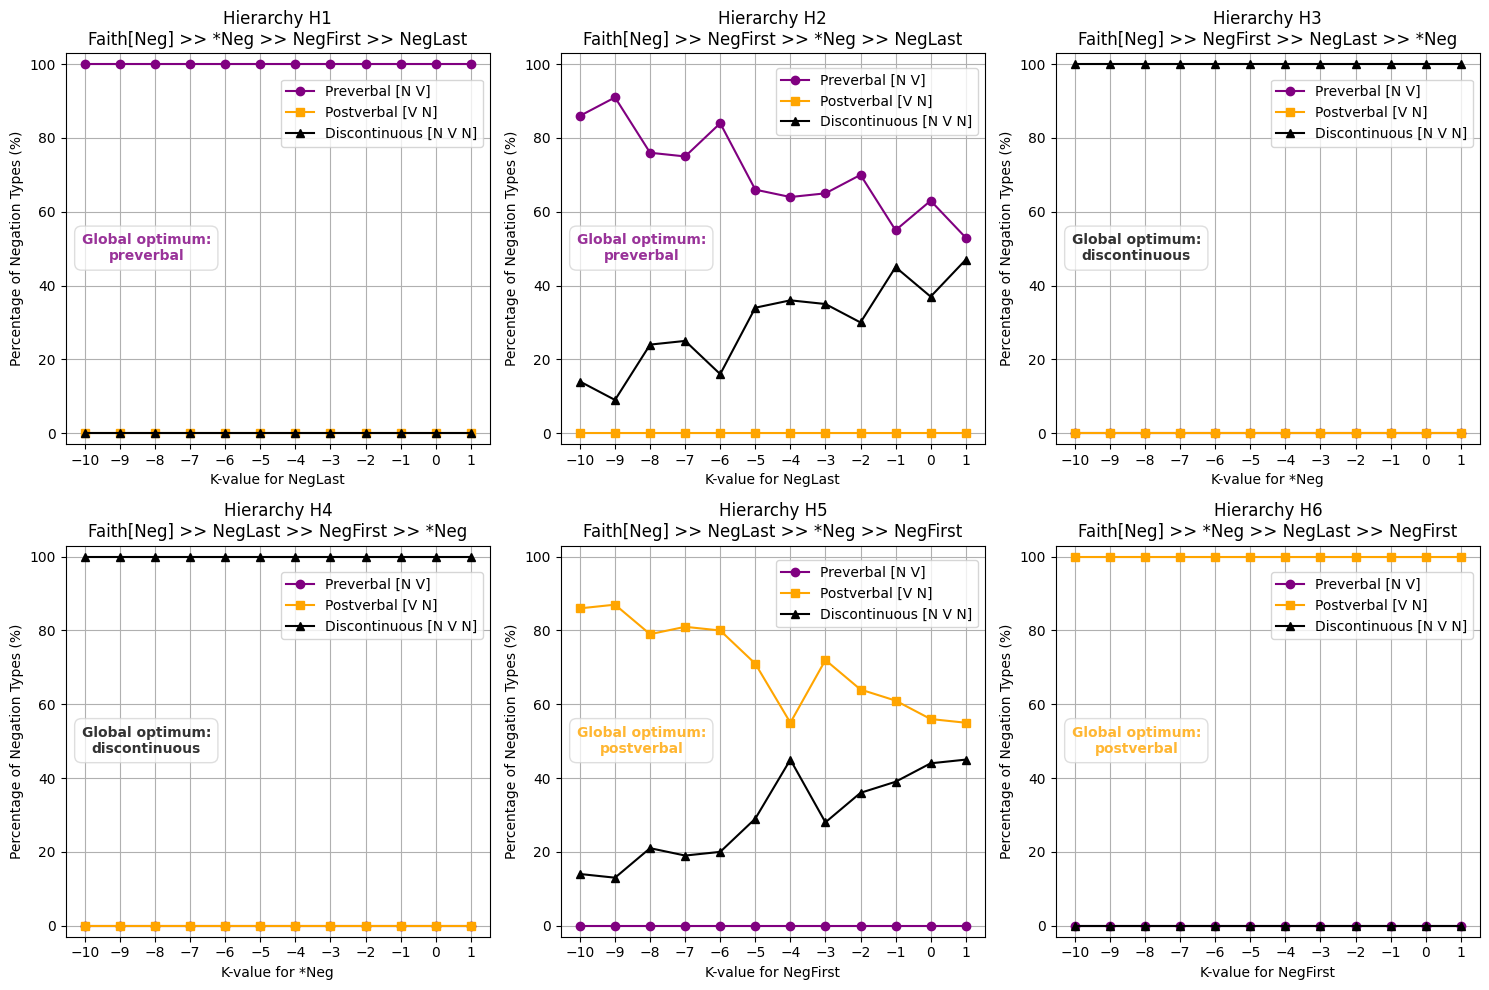

In [10]:
### Test different K-values for the lowest-ranked constraint in each hierarchy ###

total_evaluations = 100  # Number of evaluations for each K-value of the lowest-ranked constraint

# Create a 6-panel plot
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the axes array for easy access
axs = axs.flatten()

# Map each type of negation placement to a color
line_colors = {
    "preverbal": 'purple',
    "postverbal": 'orange',
    "discontinuous": 'black'
}

# Map each linearized sf string to a negation type
sf_to_neg_type = {
    "['N', 'V']": "preverbal",
    "['V', 'N']": "postverbal",
    "['N', 'V', 'N']": "discontinuous"  # NOTE: includes both ['N', ['V', 'N']] and [['N', 'V'], 'N']
}

tested_Kvalues = [i for i in range(1, -11, -1)]

# Loop over each hierarchy
for idx, (hierarchy_name, hierarchy) in enumerate(HIERARCHIES.items()):
    # Initialize counts for each K-value
    count_patterns = {i: {"preverbal": 0, "postverbal": 0, "discontinuous": 0, 'other': 0} for i in tested_Kvalues} 
    
    # Loop over K-values of the chosen constraint for testing
    for i in tested_Kvalues: 
        Kvalues = {
                hierarchy[0]: 4,
                hierarchy[1]: 3,
                hierarchy[2]: 2,
                hierarchy[3]: i
                }

        # Perform the SA-OT algorithm for each tested K-value total_evaluations times
        for _ in range(total_evaluations):
            local_optimum = sa_ot(hierarchy, Kvalues)
            # Linearize the obtained local optimum and convert it to a string to map it to a negation type
            local_optimum_type = sf_to_neg_type.get(str(linearize_tree(local_optimum)), 'other')
            # Count the candidate negation type
            count_patterns[i][local_optimum_type] += 1

    # Calculate the percentage of each type of optimum for each i
    percent_patterns = {i: {"preverbal": (count_patterns[i]["preverbal"] / total_evaluations) * 100,
                            "postverbal": (count_patterns[i]["postverbal"] / total_evaluations) * 100,
                            "discontinuous": (count_patterns[i]["discontinuous"] / total_evaluations) * 100,
                            "other": (count_patterns[i]['other'] / total_evaluations) * 100
                            } for i in tested_Kvalues} 

    # Prepare the data for plotting
    preverbal_percentages = [percent_patterns[i]["preverbal"] for i in tested_Kvalues]
    postverbal_percentages = [percent_patterns[i]["postverbal"] for i in tested_Kvalues]
    discontinuous_percentages = [percent_patterns[i]["discontinuous"] for i in tested_Kvalues]
    other_percentages = [percent_patterns[i]["other"] for i in tested_Kvalues]

    axs[idx].plot(tested_Kvalues, preverbal_percentages, marker='o', label="Preverbal [N V]", color=line_colors['preverbal'], linestyle='-', markersize=6)
    axs[idx].plot(tested_Kvalues, postverbal_percentages, marker='s', label="Postverbal [V N]", color=line_colors['postverbal'], linestyle='-', markersize=6)
    axs[idx].plot(tested_Kvalues, discontinuous_percentages, marker='^', label="Discontinuous [N V N]", color=line_colors['discontinuous'], linestyle='-', markersize=6)
    # axs[idx].plot(tested_Kvalues, other_percentages, marker='x', label="Other (3 or more N's)", color='gray', linestyle='-', markersize=6)

    ### Add global optimum to plot ###
    # Retrive the global optimum for the current hierarchy (stored in global_optima)
    global_optimum_value = global_optima[hierarchy_name]  
    # Identify the negation type of the global optimum (to match with line colors)
    global_optimum_type = sf_to_neg_type.get(str(linearize_tree(global_optimum_value)), 'unknown')
    # Get the color corresponding to the global optimum type
    global_optimum_color = line_colors.get(global_optimum_type, 'gray')
    # Add the text label for the optimal value to the plot
    axs[idx].text(0.19, 0.54, f'Global optimum:\n{global_optimum_type}', transform=axs[idx].transAxes,
                  fontsize=10, fontweight='bold', ha='center', va='top', color=global_optimum_color, alpha=0.8,
                  bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle='round,pad=0.5', alpha=0.75))
    ### End of global optimum addition ###

    axs[idx].set_title(f"Hierarchy {hierarchy_name}\n{' >> '.join(hierarchy)}")
    axs[idx].set_xlabel(f'K-value for {hierarchy[3]}')
    axs[idx].set_ylabel('Percentage of Negation Types (%)')
    axs[idx].set_ylim(-3, 103)
    axs[idx].grid(True)
    axs[idx].set_xticks(tested_Kvalues) 
    if idx == 1 or idx == 4:
        axs[idx].legend(loc='upper right', bbox_to_anchor=(1, 0.98))
    else:
        axs[idx].legend(loc='upper right', bbox_to_anchor=(1, 0.95))

plt.tight_layout()
plt.show()

In [11]:
### Expected results ###

# H1: pure preverbal
# H2: mixed (global optimum: preverbal; local optimum: discontinuous)
    # The percentage of preverbal should grow with decreasing K-value (from slightly more than 50% to almost 100%)
# H3: pure discontinuous
# H4: pure discontinuous
# H5: mixed (global optimum: postverbal; local optimum: discontinuous)
# H6: pure postverbal

# --> Achieved expected results! 

# GLA

**The GLA adjustment rule**  

When the learner's output differs from the target, the ranking values of the constraints are updated:
- **increase** the ranking of constraints that favor the target form.
- **decrease** the ranking of constraints that favor the learner's erroneous form.

In [12]:
### Helper function ### 
# to determine the hierarchy based on the constraint values

def determine_hierarchy(constraint_values):
    """
    Determine the hierarchy based on the constraint values.
    
    Args:
        constraint_values (dict): Dictionary of constraint values.
        
    Returns:
        list: The hierarchy of constraints based on the values.
    """
    hierarchy = [constraint_name for constraint_name, _ in sorted(constraint_values.items(), key=lambda x: x[1], reverse=True)]
    return hierarchy


# Test the `determine_hierarchy` function
initial_constraint_values = {
    'Faith[Neg]': 4.0, 
    '*Neg': 2.0, 
    'NegFirst': 3.0, 
    'NegLast': 1.0
}
print(initial_constraint_values)
print(determine_hierarchy(initial_constraint_values))

{'Faith[Neg]': 4.0, '*Neg': 2.0, 'NegFirst': 3.0, 'NegLast': 1.0}
['Faith[Neg]', 'NegFirst', '*Neg', 'NegLast']


In [13]:
### Gradual Learning Algorithm (GLA) ###

def gla(constraint_ranking, target_form, learner_form, learning_plasticity=0.1):
    """
    Gradual Learning Algorithm (GLA) for adjusting constraint rankings.
    
    Args:
        constraint_ranking (dict): Current rankings for constraints. 
                         Keys are constraint names (str), values are ranking scores (float).
        target_form (list): Optimal candidate (target output for the learner).
        learner_form (list): Candidate output by the learner based on current rankings.
        learning_plasticity (float, optional): Step size for ranking updates (default is 0.1).
        
    Returns:
        dict: Updated rankings for constraints.
    """
    # No updates needed if the learner's output matches the target
    if learner_form == target_form:
        return constraint_ranking

    # Update rankings when the learner's output differs from the target
    # Create a copy of `constraint_ranking` to be updated
    updated_ranking = constraint_ranking.copy()

    # Compute harmony (constraint violation marks assigned by each constraint) wrt the given hierarchy
    target_violations = harmony(target_form)
    learner_violations = harmony(learner_form)
    
    # Deduce hierarchy from constraint ranking values
    hierarchy = determine_hierarchy(updated_ranking)
    
    # Go over constraints in the order of the hierarchy
    for constraint in hierarchy:
        # Compare violations to determine whether the constraint favors the target or the learner
        target_violation_count = target_violations.get(constraint, 0)
        learner_violation_count = learner_violations.get(constraint, 0)

        # If constraint favors target, increase its ranking by one step
        if target_violation_count < learner_violation_count:
            updated_ranking[constraint] += learning_plasticity
        # If constraint favors learner, decrease its ranking by one step
        elif target_violation_count > learner_violation_count:
            updated_ranking[constraint] -= learning_plasticity

    return updated_ranking


# Test `gla` function
constraint_values = {constraint:float(i) for constraint,i in zip(HIERARCHIES["H1"], range(4,0,-1))}  # Hierarchy 1 with K-values from 4 down to 1 
print(f'Original ranking:\n\t{constraint_values}')
print(f"Target form: ['V','N']\tLearner form: ['N','V']")
updated_ranking = gla(constraint_ranking=constraint_values, target_form=["V","N"], learner_form=["N","V"])
print(f'Updated ranking:\n\t{updated_ranking}')

Original ranking:
	{'Faith[Neg]': 4.0, '*Neg': 3.0, 'NegFirst': 2.0, 'NegLast': 1.0}
Target form: ['V','N']	Learner form: ['N','V']
Updated ranking:
	{'Faith[Neg]': 4.0, '*Neg': 3.0, 'NegFirst': 1.9, 'NegLast': 1.1}


# ABM

## Model Definition

In [14]:
### SA-OT Agent Class ###

class SAOTAgent(Agent):
    """
    A Simulated Annealing Optimality Theory (SA-OT) agent for language simulation.
    
    The agent represents an individual with a grammar, modeled as a hierarchy of ranked constraints. 
    The agent:
    - Produces linguistic utterances (candidates) using SA-OT.
    - Adjusts its grammar iteratively through the Gradual Learning Algorithm (GLA) based on 
      a comparison between its production and target linguistic forms.
    
    Attributes:
        unique_id (int): A unique identifier for the agent within the simulation.
        model: The overall model or environment the agent is a part of.
        constraint_values (dict): The current ranking values of constraints in the grammar.
        hierarchy (list): The ranking hierarchy of constraints derived from their values.
    """
    
    def __init__(self, unique_id, model, initial_constraint_values):
        """
        Initialize the SA-OT agent with a unique ID, the simulation model, and initial grammar.
        
        Args:
            unique_id (int): A unique identifier for the agent.
            model: The simulation model the agent operates within.
            initial_constraint_values (dict): Initial ranking values for the grammar constraints.
        """
        super().__init__(unique_id, model)
        self.constraint_values = initial_constraint_values
        self.hierarchy = determine_hierarchy(self.constraint_values)
    
    def generate_utterance(self, polarity=None, max_tries=100):
        """
        Generate an utterance based on the agent's current grammar using the SA-OT algorithm. 
        A given polarity can be enforced for the underlying form.
        
        Uses simulated annealing to optimize linguistic candidates according to the hierarchy 
        of constraints. The initial candidate is the minimal surface form (["V"] for a bare 
        verb). See `sa_ot` function for more details.
        
        Args:
            polarity (str, optional): Desired polarity of the underlying form ('negative' or 'positive').
            max_tries (int, optional): Maximum number of attempts to generate a candidate with the desired polarity.
        
        Returns:
            list (of lists): The optimal linguistic candidate (utterance) selected by SA-OT.
        """
        candidate = sa_ot(self.hierarchy, Kvalues=self.constraint_values)
        
        # Generate a candidate with the desired polarity if specified
        if polarity == 'negative':
            count = 0
            while 'N' not in linearize_tree(candidate):
                if count > max_tries:
                    print("Max tries to produce negative utterance reached.")
                    break 
                candidate = sa_ot(self.hierarchy, Kvalues=self.constraint_values)
                count += 1
        elif polarity == 'positive':
            count = 0
            while 'N' in linearize_tree(candidate):
                if count > max_tries:
                    print("Max tries to produce positive utterance reached.")
                    break 
                candidate = sa_ot(self.hierarchy, Kvalues=self.constraint_values)
                count += 1
        
        return candidate
    
    def learn(self, target_form, learner_form, step_size=0.1):
        """
        Update the agent's grammar based on learning data using the Gradual Learning Algorithm (GLA).
        
        The GLA compares the agent's produced form to a target adult form, adjusting constraint 
        rankings incrementally to improve alignment with the input. The updated constraint values 
        are used to rederive the ranking hierarchy. See `gla` function for more details.
        
        Args:
            target_form (list): The adult (target) linguistic form.
            learner_form (list): The form produced by the agent.
            step_size (float, optional): The magnitude of adjustment for constraint values during learning. 
                                         Defaults to 0.1.
        """
        self.constraint_values = gla(self.constraint_values, target_form, learner_form, step_size)  
        self.hierarchy = determine_hierarchy(self.constraint_values)

In [15]:
class SAOTModel(Model):
    def __init__(self, n_agents=5, n_generations=100, n_learning_data=300, n_production_samples=500, gen0_grammar=None, gla_step_size=0.1, seed=42):
        """
        Initialize the SAOTModel with simulation parameters and create the first generation of agents.
        
        Args:
            n_agents (int): Number of agents per generation. Default is 5.
            n_generations (int): Total number of generations to simulate. Default is 100.
            n_learning_data (int): Number of 'adult' utterances each agent learns from. Default is 300.
            n_production_samples (int): Number of production samples recorded per generation. Default is 500.
            gen0_grammar (dict, optional): Initial grammar for generation 0 agents. Default is None, 
                                           which will initialize Hierarchy 1 with rank values from 4 down to 1.
            gla_step_size (float): Step size (plasticity) for constraint value updates in GLA. Default is 0.1.
        """
        super().__init__()
        if seed is not None:
            self.seed = seed
            random.seed(self.seed)
            self.random.seed(self.seed)
        self.n_agents = n_agents
        self.n_generations = n_generations
        self.n_learning_data = n_learning_data
        self.n_production_samples = n_production_samples
        assert self.n_production_samples >= self.n_learning_data, "Production samples must be >= learning data."
        self.production_samples = {}
        self.gen0_grammar = gen0_grammar if gen0_grammar is not None else {
            'Faith[Neg]': 4.0, 
            '*Neg':       3.0, 
            'NegFirst':   2.0, 
            'NegLast':    1.0
            }
        self.gla_step_size = gla_step_size
        self.current_generation = 0
        self.next_agent_id = 1
        self.HIERARCHIES = {
            "H1": ["Faith[Neg]", "*Neg",     "NegFirst", "NegLast"],
            "H2": ["Faith[Neg]", "NegFirst", "*Neg",     "NegLast"],
            "H3": ["Faith[Neg]", "NegFirst", "NegLast",  "*Neg"], 
            "H4": ["Faith[Neg]", "NegLast",  "NegFirst", "*Neg"],
            "H5": ["Faith[Neg]", "NegLast",  "*Neg",     "NegFirst"],
            "H6": ["Faith[Neg]", "*Neg",     "NegLast",  "NegFirst"]
        }
        self.datacollector = DataCollector(
            agent_reporters={"Hierarchy": "hierarchy"},
            model_reporters={"ProductionSamples": lambda m: m.production_samples[m.current_generation]}
        )
        self.schedule = SimultaneousActivation(self) 
        self.running = True
        # Initialize the first generation of agents
        self.init_population()

    def init_population(self):
        """Initialize agents for the first generation."""
        for _ in range(self.n_agents):
            agent = SAOTAgent(self.next_agent_id, self, self.gen0_grammar)
            self.schedule.add(agent)
            self.next_agent_id += 1
        self.current_generation += 1

    def record_production_samples(self, agents):
        """
        Collect and store production samples for the current generation.
        Ensures equal sampling from agents and adjusts to meet the required sample size.
        
        Args:
            agents (list): The agents from which samples are collected.
        """
        samples = []
        # Record an equal number of samples from each agent
        samples_per_agent = self.n_production_samples // len(agents)
        for agent in agents:
            for _ in range(samples_per_agent):
                samples.append(agent.generate_utterance()) 
        
        # If not enough samples were collected, record the remaining from randomly chosen agents
        while len(samples) < self.n_production_samples:
            samples.append(random.choice(agents).generate_utterance()) 
        
        self.production_samples[self.current_generation] = samples

    def step(self):
        """
        Simulate one generation: 
        - creating new generation of agents, 
        - ajdusting their grammars based on learning data from the previous generation, 
        - recording a production sample once learning is done,
        - replacing the old generation with the new one.
        """
        # Create next generation of agents and expose them to learning data        
        new_agents = []
        for _ in range(self.n_agents):
            # Initialize a new agent with a unique ID and a randomly chosen hierarchy
            hierarchy = random.choice(list(self.HIERARCHIES.values()))
            # Assign constraint values based on the hierarchy
            constraint_values = {constraint: float(i) for constraint, i in zip(hierarchy, range(4, 0, -1))}
            # Create a new agent with the assigned constraint values
            learner = SAOTAgent(self.next_agent_id, self, constraint_values)
            
            # Generate learning data for the new agent
            for _ in range(self.n_learning_data):
                # Randomly select an adult agent from the previous generation
                adult_agent = random.choice(self.schedule.agents)
                # Adult generates an utterance with negative polarity using SA-OT
                adult_production = adult_agent.generate_utterance(polarity='negative') 
                # Learner generate an utterance using SA-OT
                learner_production = learner.generate_utterance() 
                # Compare the learner's production to the adult's production and update the learner's grammar
                learner.learn(adult_production, learner_production, self.gla_step_size)
            
            # Add the learner to the new generation
            new_agents.append(learner)
            self.next_agent_id += 1  # Increment the unique agent ID for the next agent
            
        # Record production samples from the new generation
        self.record_production_samples(new_agents)
        self.datacollector.collect(self)
        
        # Replace the old generation with the new one
        self.schedule = SimultaneousActivation(self)  # Reset the scheduler
        for agent in new_agents:
            self.schedule.add(agent)  # Add the new agents to the scheduler
        
        self.current_generation += 1  # Increment the generation counter

    def run_model(self):
        """
        Run the simulation for the specified number of generations and log progress.
        """
        for _ in range(self.n_generations):
            self.step()
            if (self.current_generation-1) % 10 == 0:
                print(f"Generation {self.current_generation-1}/{self.n_generations} completed.")

## 1 Run (+ data saving & plot)

In [ ]:
# Run the model
model = SAOTModel(
    n_agents=5,
    n_generations=100,
    n_learning_data=25,
    n_production_samples=500,
    gla_step_size = 0.1,
    seed=SEED
)
model.run_model()

Generation 10/100 completed.
Generation 20/100 completed.
Generation 30/100 completed.
Generation 40/100 completed.
Generation 50/100 completed.
Generation 60/100 completed.
Generation 70/100 completed.
Generation 80/100 completed.
Generation 90/100 completed.
Generation 100/100 completed.


In [17]:
def calculate_grammar_distributions(model):
    """
    Calculate the distribution of negation types across generations from recorded production samples.
    
    Args:
        model (SAOTModel): The SA-OT model instance.
    
    Returns:
        dict: Negation type usage percentages by generation.
    """
    # Retrieve model data
    model_data = model.datacollector.get_model_vars_dataframe()
    # display(model_data.head())
    
    # Count samples for each type of grammar in a single loop
    grammar_percents = {gen: {"preverbal": 0, "postverbal": 0, "discontinuous": 0, "other": 0} 
                    for gen in range(model.n_generations)}

    for gen, samples in enumerate(model_data["ProductionSamples"]):
        total_samples = len(samples)
        if total_samples == 0:
            print(f'No samples for generation {gen}')
            continue
        
        # Count the number of samples for each type of grammar
        for sample in samples:
            if sample == ['N', 'V']:
                grammar_percents[gen]["preverbal"] += 1
            elif sample == ['V', 'N']:
                grammar_percents[gen]["postverbal"] += 1
            elif linearize_tree(sample) == ['N', 'V', 'N']:
                grammar_percents[gen]["discontinuous"] += 1
            else:
                grammar_percents[gen]["other"] += 1
        
        # Calculate the percentage of each type of grammar for the current generation
        for neg_type in grammar_percents[gen]:
            grammar_percents[gen][neg_type] = (grammar_percents[gen][neg_type] / total_samples) * 100
    
    return grammar_percents

In [18]:
performance_distr = calculate_grammar_distributions(model)

# Convert the dictionary into a DataFrame
performance_df = pd.DataFrame.from_dict(performance_distr, orient="index")

# Add the 'Generation' column (add index as a regular column)
performance_df.reset_index(inplace=True)
performance_df.rename(columns={'index': 'Generation'}, inplace=True)

display(performance_df.head())

# Save to CSV
performance_distr_path = "outputs/performance_distribution_25.csv"
performance_df.to_csv(performance_distr_path, index=False)

,Generation,preverbal,postverbal,discontinuous,other
0,0,100.0,0.0,0.0,0.0
1,1,100.0,0.0,0.0,0.0
2,2,80.0,0.0,20.0,0.0
3,3,80.6,0.0,19.4,0.0
4,4,73.0,0.0,27.0,0.0


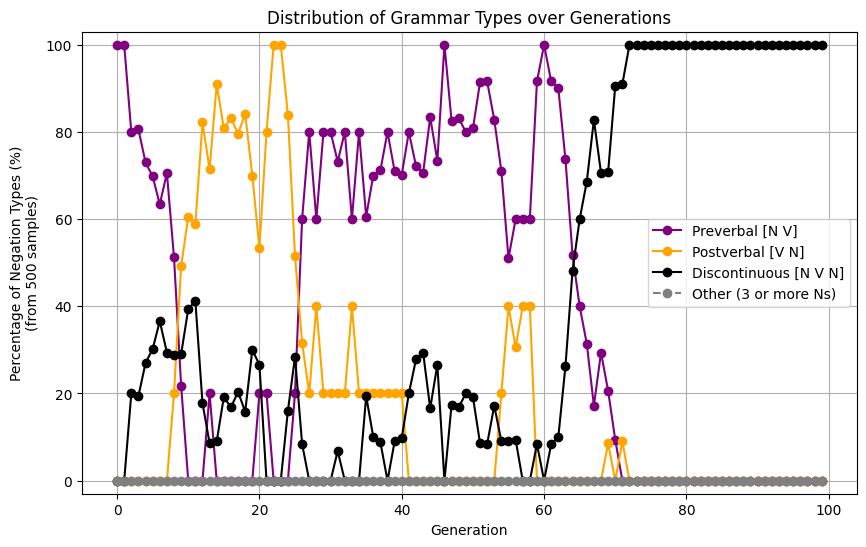

In [19]:
def plot_grammar_distributions(grammar_distributions, save_path=None):
    """Plot the grammar distributions as line plots over generations."""
    # Extract data for each grammar type
    generations = list(grammar_distributions.keys())
    preverbal_counts = [grammar_distributions[gen]['preverbal'] for gen in generations]
    postverbal_counts = [grammar_distributions[gen]['postverbal'] for gen in generations]
    discontinuous_counts = [grammar_distributions[gen]['discontinuous'] for gen in generations]
    other_counts = [grammar_distributions[gen]['other'] for gen in generations]
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(generations, preverbal_counts, label='Preverbal [N V]', color='purple', marker='o')
    plt.plot(generations, postverbal_counts, label='Postverbal [V N]', color='orange', marker='o')
    plt.plot(generations, discontinuous_counts, label='Discontinuous [N V N]', color='black', marker='o')
    plt.plot(generations, other_counts, label='Other (3 or more Ns)', color='gray', marker='o', linestyle='--')
    
    # Add labels, legend, and title
    plt.xlabel('Generation')
    plt.ylabel('Percentage of Negation Types (%)\n(from 500 samples)')
    plt.ylim(-3, 103)
    plt.title('Distribution of Grammar Types over Generations')
    plt.legend()
    plt.grid(True)
    if save_path:
        plt.savefig(save_path)
    plt.show()

# Plot the grammar distributions
plot_grammar_distributions(performance_distr)

In [20]:
def calculate_hierarchy_distributions(agent_data):
    """
    Calculate the distribution of hierarchies across generations from agent data.
    
    Args:
        model (SAOTModel): The SA-OT model instance.
    
    Returns:
        dict: Hierarchy usage percentages per generation.
    """
    # Retrieve agent data
    agent_data = model.datacollector.get_agent_vars_dataframe()
    
    # Map the Hierarchy values to their abbreviated names
    hierarchy_mapping = {tuple(value): key for key, value in model.HIERARCHIES.items()}
    agent_data['Hierarchy'] = agent_data['Hierarchy'].apply(lambda h: hierarchy_mapping.get(tuple(h), "Unknown"))
    
    hierarchy_percents = {}
    
    # Group agents by generation
    generations = agent_data.groupby("Step")  
    
    for gen, group in generations:
        total_agents = len(group)
        if total_agents == 0:
            print(f"No agents for generation {gen}")
            continue
        
        # Count occurrences of each hierarchy
        hierarchy_counts = group["Hierarchy"].value_counts().to_dict()
        
        # Convert counts to percentages
        hierarchy_percents[gen] = {hierarchy: (count / total_agents) * 100 for hierarchy, count in hierarchy_counts.items()}
    
    return hierarchy_percents

In [21]:
competence_distr = calculate_grammar_distributions(model)

# Convert the dictionary into a DataFrame
competence_df = pd.DataFrame.from_dict(competence_distr, orient="index")

# Add the 'Generation' column (add index as a regular column)
competence_df.reset_index(inplace=True)
competence_df.rename(columns={'index': 'Generation'}, inplace=True)

display(competence_df.head())
print(len(competence_df))
# Save to CSV
competence_distr_path = "outputs/competence_distribution_25.csv"
competence_df.to_csv(competence_distr_path, index=False)

,Generation,preverbal,postverbal,discontinuous,other
0,0,100.0,0.0,0.0,0.0
1,1,100.0,0.0,0.0,0.0
2,2,80.0,0.0,20.0,0.0
3,3,80.6,0.0,19.4,0.0
4,4,73.0,0.0,27.0,0.0


100


## Repeat simulation + Plot results

In [22]:
NUM_REPS = 20

all_grammar_distributions = []

for rep, seed in zip(range(NUM_REPS), range(42, 42+NUM_REPS)):
    model = SAOTModel(
        n_agents=5,
        n_generations=100,
        n_learning_data=25,
        n_production_samples=500,
        gla_step_size = 0.1,
        seed=seed
    )
    print(f"Started repetition {rep+1} (seed {seed})...")
    model.run_model()
    grammar_distributions = calculate_grammar_distributions(model)
    all_grammar_distributions.append(grammar_distributions)
    print(f"Completed repetition {rep+1} (seed {seed})")

# Save the aggregated grammar distributions
all_distributions_df = pd.DataFrame(all_grammar_distributions)
all_distributions_df.to_csv(os.path.join("outputs", f"grammar_distributions_25_{NUM_REPS}reps.csv"), index=False)

Started repetition 1 (seed 42)...
Generation 10/100 completed.
Generation 20/100 completed.
Generation 30/100 completed.
Generation 40/100 completed.
Generation 50/100 completed.
Generation 60/100 completed.
Generation 70/100 completed.
Generation 80/100 completed.
Generation 90/100 completed.
Generation 100/100 completed.
Completed repetition 1 (seed 42)
Started repetition 2 (seed 43)...
Generation 10/100 completed.
Generation 20/100 completed.
Generation 30/100 completed.
Generation 40/100 completed.
Generation 50/100 completed.
Generation 60/100 completed.
Generation 70/100 completed.
Generation 80/100 completed.
Generation 90/100 completed.
Generation 100/100 completed.
Completed repetition 2 (seed 43)
Started repetition 3 (seed 44)...
Generation 10/100 completed.
Generation 20/100 completed.
Generation 30/100 completed.
Generation 40/100 completed.
Generation 50/100 completed.
Generation 60/100 completed.
Generation 70/100 completed.
Generation 80/100 completed.
Generation 90/100 

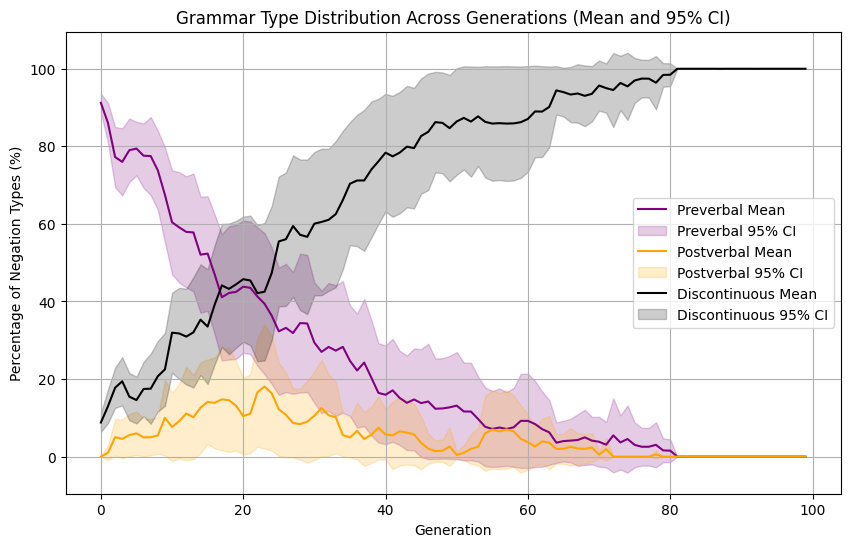

In [23]:
# Calculate mean and confidence intervals
def compute_mean_ci(distributions_reps, grammar_type):
    """
    Compute mean and confidence intervals for a given grammar type across generations.

    Args:
        distributions_reps: List of dictionaries containing grammar counts across generations.
        grammar_type: One of 'preverbal', 'postverbal', 'discontinuous'.

    Returns:
        generations: List of generations.
        mean_values: Mean of the grammar type at each generation.
        lower_bound: Lower confidence interval bounds.
        upper_bound: Upper confidence interval bounds.
    """
    generations = list(distributions_reps[0].keys())
    all_counts = {gen: [] for gen in generations}

    # Gather data for the specified grammar type across all repetitions
    for rep in distributions_reps:
        for gen in generations:
            all_counts[gen].append(rep[gen][grammar_type])

    # Compute mean and confidence intervals
    mean_values = []
    lower_bound = []
    upper_bound = []

    for gen in generations:
        data = np.array(all_counts[gen])
        mean = np.mean(data)
        std_err = np.std(data) / np.sqrt(len(data))  # Standard Error of the Mean
        ci = 1.96 * std_err  # Approx. 95% Confidence Interval
        mean_values.append(mean)
        lower_bound.append(mean - ci)
        upper_bound.append(mean + ci)

    return generations, mean_values, lower_bound, upper_bound


# Plot mean results of all runs with confidence intervals
plt.figure(figsize=(10, 6))

for grammar_type, color in [('preverbal', 'purple'), ('postverbal', 'orange'), ('discontinuous', 'black')]:
    gens, means, lowers, uppers = compute_mean_ci(all_grammar_distributions, grammar_type)
    plt.plot(gens, means, label=f'{grammar_type.capitalize()} Mean', color=color)
    plt.fill_between(gens, lowers, uppers, color=color, alpha=0.2, label=f'{grammar_type.capitalize()} 95% CI')

plt.xlabel('Generation')
plt.ylabel('Percentage of Negation Types (%)')
plt.title('Grammar Type Distribution Across Generations (Mean and 95% CI)')
plt.legend()
plt.grid(True)
plt.show()

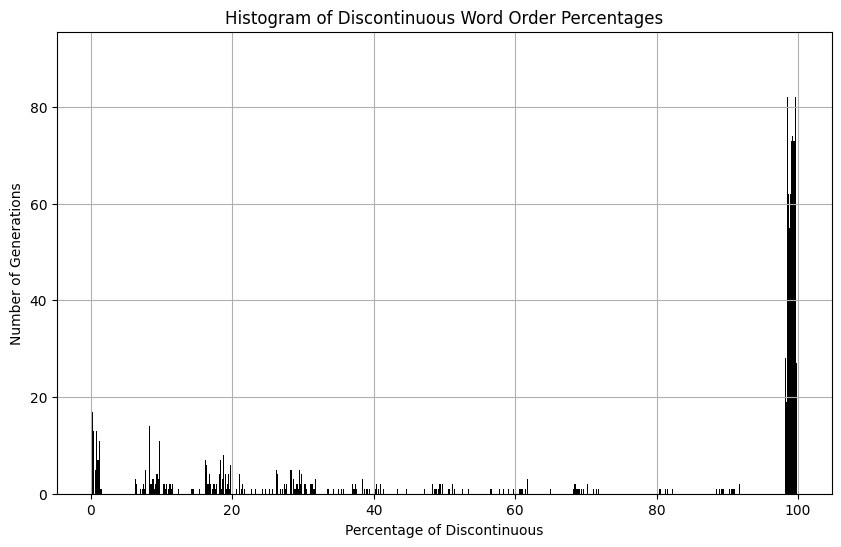

In [31]:
# Plot a histogram of the number of generations for each percentage of discontinuous grammars
discontinuous_percentages = []
for grammar_distributions in all_grammar_distributions:
    discontinuous_percentages.append([gen['discontinuous'] for gen in grammar_distributions.values()])

plt.figure(figsize=(10, 6))
plt.hist(discontinuous_percentages, bins=50, color=['black']*len(all_grammar_distributions))  # , histtype='barstacked'
plt.xlabel('Percentage of Discontinuous')
plt.ylabel('Number of Generations')
plt.title('Histogram of Discontinuous Word Order Percentages')
plt.grid(True)


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import data from the CSV file
all_grammar_distributions = pd.read_csv("outputs/grammar_distributions_25_20reps.csv")
# convert it to a list
all_grammar_distributions = all_grammar_distributions.to_dict(orient='records')
# convert string indices to integers
all_grammar_distributions = [{int(k): v for k, v in d.items()} for d in all_grammar_distributions]

In [42]:
# Filter out samples where the percentage of discontinuous grammar is 100%
filtered_discontinuous_percentages = []
for grammar_distributions in all_grammar_distributions:
    filtered_discontinuous_percentages.append([gen['discontinuous'] for gen in grammar_distributions.values() if gen['discontinuous'] < 100])

plt.figure(figsize=(10, 6))
plt.hist(filtered_discontinuous_percentages, bins=50, color=['black'] * len(filtered_discontinuous_percentages))
plt.xlabel('Percentage of Discontinuous')
plt.xticks(range(0, 101, 10))
plt.ylabel('Number of Generations')
plt.title('Histogram of Discontinuous Word Order Percentages (Excluding 100%)')
plt.grid(True)
plt.show()

TypeError: string indices must be integers

## Parameter testing

--- Start running for n_learning_data=10 ---
Generation 10/100 completed.
Generation 20/100 completed.
Generation 30/100 completed.
Generation 40/100 completed.
Generation 50/100 completed.
Generation 60/100 completed.
Generation 70/100 completed.
Generation 80/100 completed.
Generation 90/100 completed.
Generation 100/100 completed.
Done running for n_learning_data=10
Saved grammar distributions for n_learning_data=10


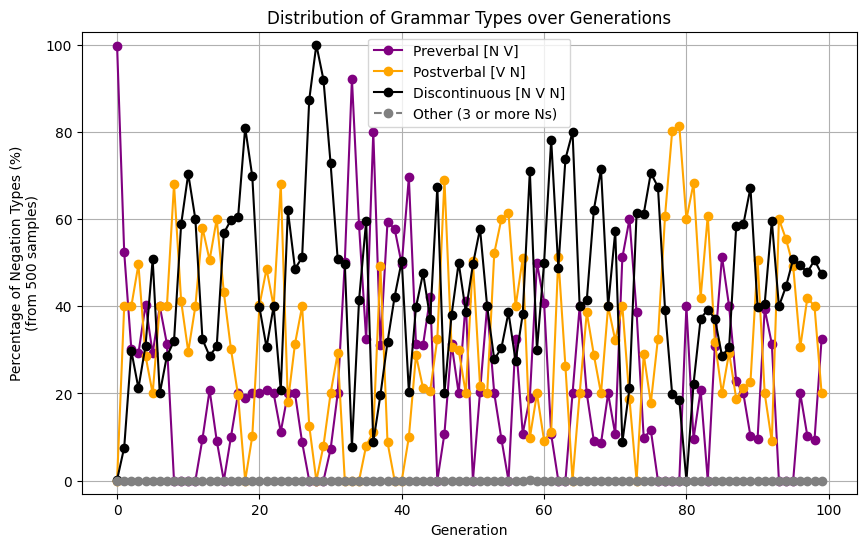

Saved plot for i=10
--- Start running for n_learning_data=20 ---
Generation 10/100 completed.
Generation 20/100 completed.
Generation 30/100 completed.
Generation 40/100 completed.
Generation 50/100 completed.
Generation 60/100 completed.
Generation 70/100 completed.
Generation 80/100 completed.
Generation 90/100 completed.
Generation 100/100 completed.
Done running for n_learning_data=20
Saved grammar distributions for n_learning_data=20


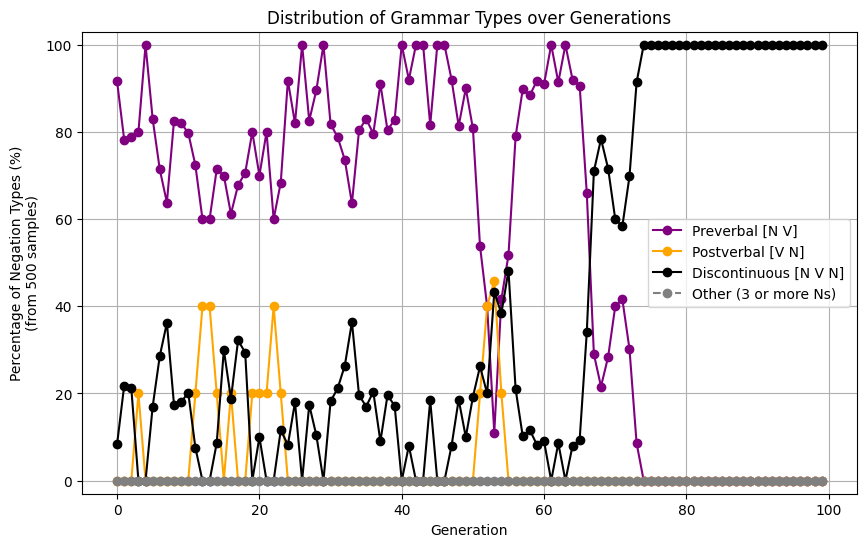

Saved plot for i=20
--- Start running for n_learning_data=30 ---
Generation 10/100 completed.
Generation 20/100 completed.
Generation 30/100 completed.
Generation 40/100 completed.
Generation 50/100 completed.
Generation 60/100 completed.
Generation 70/100 completed.
Generation 80/100 completed.
Generation 90/100 completed.
Generation 100/100 completed.
Done running for n_learning_data=30
Saved grammar distributions for n_learning_data=30


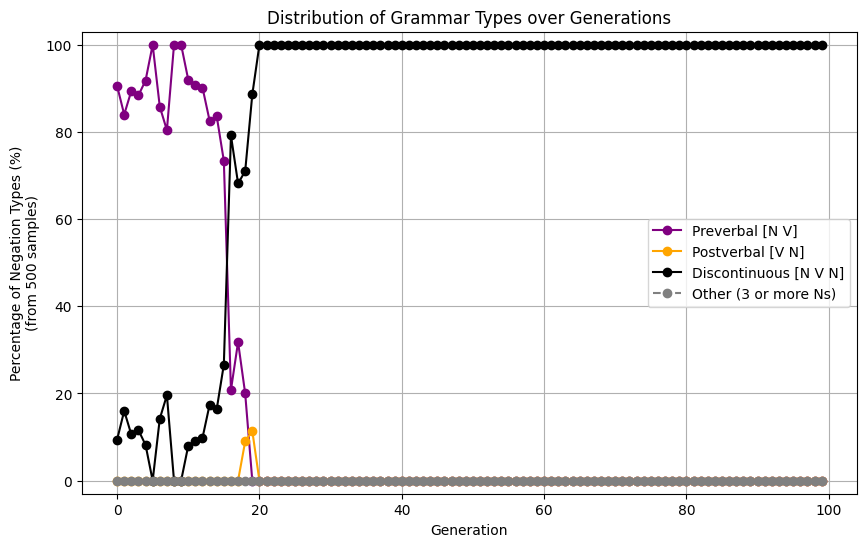

Saved plot for i=30
--- Start running for n_learning_data=50 ---
Generation 10/100 completed.
Generation 20/100 completed.
Generation 30/100 completed.
Generation 40/100 completed.
Generation 50/100 completed.
Generation 60/100 completed.
Generation 70/100 completed.
Generation 80/100 completed.
Generation 90/100 completed.
Generation 100/100 completed.
Done running for n_learning_data=50
Saved grammar distributions for n_learning_data=50


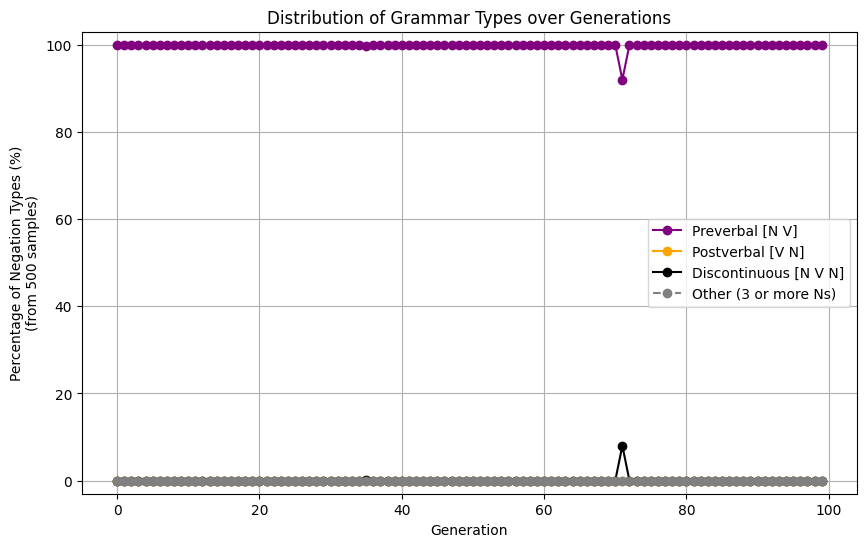

Saved plot for i=50
--- Start running for n_learning_data=100 ---
Generation 10/100 completed.
Generation 20/100 completed.
Generation 30/100 completed.
Generation 40/100 completed.
Generation 50/100 completed.
Generation 60/100 completed.
Generation 70/100 completed.
Generation 80/100 completed.
Generation 90/100 completed.
Generation 100/100 completed.
Done running for n_learning_data=100
Saved grammar distributions for n_learning_data=100


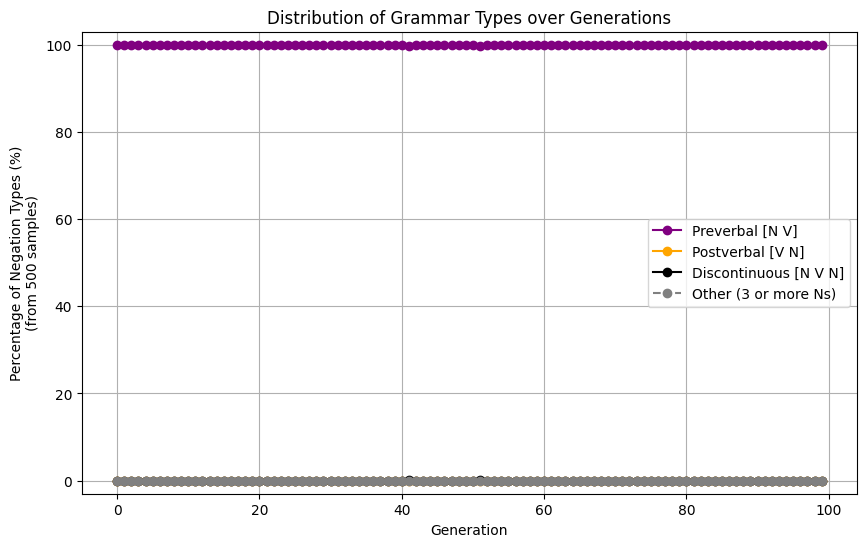

Saved plot for i=100
--- Start running for n_learning_data=200 ---
Generation 10/100 completed.
Generation 20/100 completed.
Generation 30/100 completed.
Generation 40/100 completed.
Generation 50/100 completed.
Generation 60/100 completed.
Generation 70/100 completed.
Generation 80/100 completed.
Generation 90/100 completed.
Generation 100/100 completed.
Done running for n_learning_data=200
Saved grammar distributions for n_learning_data=200


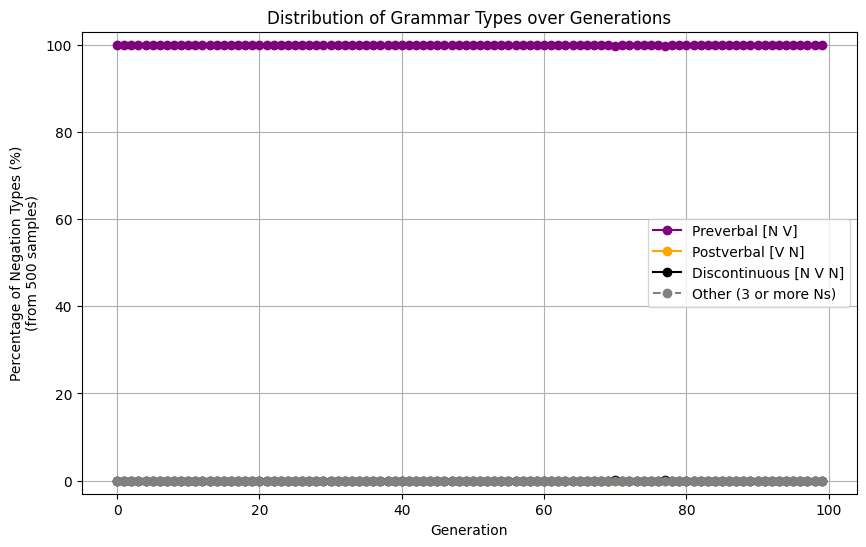

Saved plot for i=200
--- Start running for n_learning_data=300 ---
Generation 10/100 completed.
Generation 20/100 completed.
Generation 30/100 completed.
Generation 40/100 completed.
Generation 50/100 completed.
Generation 60/100 completed.
Generation 70/100 completed.
Generation 80/100 completed.
Generation 90/100 completed.
Generation 100/100 completed.
Done running for n_learning_data=300
Saved grammar distributions for n_learning_data=300


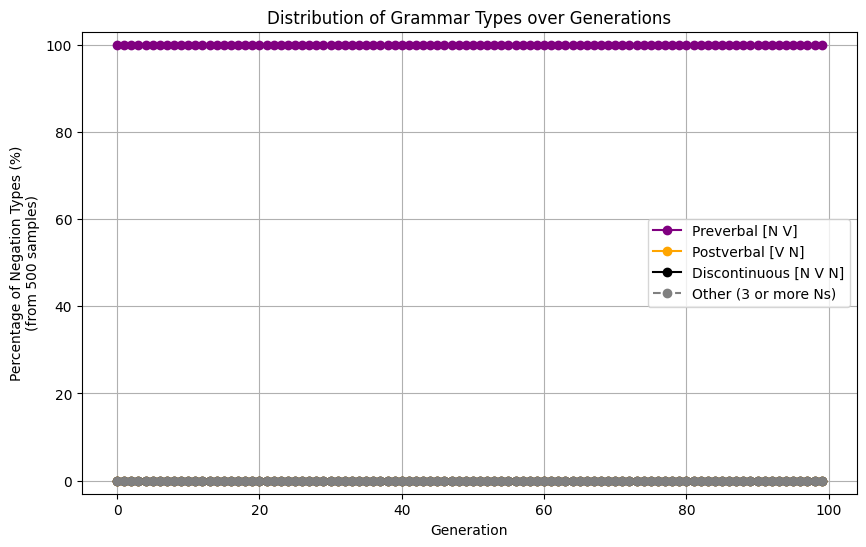

Saved plot for i=300


In [38]:
### n_learning_data ###

# Directory to save plots
outputs_dir = os.path.join("outputs", "n_learning_data")
plots_dir = os.path.join("plots", "n_learning_data")
os.makedirs(outputs_dir, exist_ok=True)  
os.makedirs(plots_dir, exist_ok=True)  

# Run the model with diffent values of `n_learning_data` (number of adult utterances each agent learns from)
for i in [10, 20, 30, 50, 100, 200, 300]:
    print(f"--- Start running for n_learning_data={i} ---")
    # Run the model
    model = SAOTModel(
        n_agents=5,
        n_generations=100,
        n_learning_data=i,
        n_production_samples=500,
        max_no_move=50,
        gla_step_size=0.1,
        seed=SEED
    )
    model.run_model()
    print(f"Done running for n_learning_data={i}")
    grammar_distributions = calculate_grammar_distributions(model)
    
    # Save the obtained grammar distributions for the current n_learning_data value
    df = pd.DataFrame.from_dict(grammar_distributions, orient="index")
    # Add the 'Generation' column (index as a regular column)
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'Generation'}, inplace=True)
    df.to_csv(os.path.join(outputs_dir, f"learning_data_{i}.csv"), index=False)
    print(f"Saved grammar distributions for n_learning_data={i}")
    
    # Save plot for each max_no_move value
    plot_path = os.path.join(plots_dir, f"learning_data_{i}.png")
    plot_grammar_distributions(grammar_distributions, save_path=plot_path) 
    print(f"Saved plot for n_learning_data={i}")